<center>
    <h1>Assignment 2 - Question Answering with Transformers on CoQA</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>



---



Assignment description: see `Assignment.ipynb`.

In this notebook the QA task is addressed.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `utils` folder.

In [109]:
import json
import numpy as np
import pandas as pd
import torch

In [110]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
# Settings for reproducibility
from utils.seeder import set_random_seed

set_random_seed(42)

# [Task 1] Remove unaswerable QA pairs

## 1.1 Dataset download

The dataset is downloaded and saved in the `coqua` folder using the snippet of code provided in `Assignment.ipynb`.

In [112]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [113]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

## 1.2 Dataframe Creation

The train and test dataframes (`train_df` and `test_df`) are built. Each row contains information about a specific question and the corresponding answer along with their chronological collocation (`turn_id`) in the conversation. Furthermore informations about the passage containing the context and the history of previous questions and answers of the relative conversation is contained.

In [114]:
from utils.dataframe_builder import get_dataframe

train_df = get_dataframe(os.path.join('coqa', 'train.json'))
test_df = get_dataframe(os.path.join('coqa', 'test.json'))


## 1.3 Data Inspection

The heads of the train and test dataframes are shown below along with their shapes.

In [115]:
print(f'Train dataframe shape: {train_df.shape}')
train_df.head()

Train dataframe shape: (108647, 15)


,source,id,filename,story,name,question_input_text,question_turn_id,question_bad_turn,answer_span_start,answer_span_end,answer_span_text,answer_input_text,answer_turn_id,answer_bad_turn,history
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,When was the Vat formally opened?,1,NaN,151,179,Formally established in 1475,It was formally established in 1475,1,NaN,[]
1,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,what is the library for?,2,NaN,454,494,he Vatican Library is a research library,research,2,NaN,"[When was the Vat formally opened?, It was for..."
2,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,for what subjects?,3,NaN,457,511,Vatican Library is a research library for hist...,"history, and law",3,NaN,"[When was the Vat formally opened?, It was for..."
3,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,and?,4,NaN,457,545,Vatican Library is a research library for hist...,"philosophy, science and theology",4,NaN,"[When was the Vat formally opened?, It was for..."
4,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,what was started in 2014?,5,NaN,769,879,"March 2014, the Vatican Library began an initi...",a project,5,NaN,"[When was the Vat formally opened?, It was for..."


In [116]:
print(f'Test dataframe shape: {test_df.shape}')
test_df.head()

Test dataframe shape: (7983, 14)


,source,id,filename,story,additional_answers,name,question_input_text,question_turn_id,answer_span_start,answer_span_end,answer_span_text,answer_input_text,answer_turn_id,history
0,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,What color was Cotton?,1,59,93,a little white kitten named Cotton,white,1,[]
1,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Where did she live?,2,18,80,"in a barn near a farm house, there lived a lit...",in a barn,2,"[What color was Cotton?, white]"
2,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Did she live alone?,3,196,215,Cotton wasn't alone,no,3,"[What color was Cotton?, white, Where did she ..."
3,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Who did she live with?,4,281,315,with her mommy and 5 other sisters,with her mommy and 5 sisters,4,"[What color was Cotton?, white, Where did she ..."
4,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,What color were her sisters?,5,428,490,her sisters were all orange with beautiful whi...,orange and white,5,"[What color was Cotton?, white, Where did she ..."


We can observe that the training dataframe contains $15$ different features, while the test dataframe has just $14$. In particular the train dataframe includes the additional features `question_bad_turn` and `answer_bad_turn`. With a quick inspection of the dataframe's head it can be observed that they include `NaN` values. Since the task requires to remove solely unanswerable question-answer pairs, not mentioning the handling of "bad turn", these two features are dropped.

On the other hand the test dataframe contains the extra feature `additional_answers`, which can be removed as expressed in the specifications of the assignment.

In [117]:
# Drop non-matching features

train_df.drop(['question_bad_turn', 'answer_bad_turn'], axis=1, inplace=True)
test_df.drop('additional_answers', axis=1, inplace=True)

In addition the features `name` and `filename` are removed since they are considered useless for the task.

In [118]:
# Drop useless columns (`name`, `filename`)

train_df.drop(['name', 'filename'], axis=1, inplace=True)
test_df.drop(['name', 'filename'], axis=1, inplace=True)

Next, by inspecting the `question_turn_id` and `answer_turn_id` it can be noticed that they are equivalent, since they refer to the same question-answer pair, hence they can be merged in a single feature (`turn_id`).

In [119]:
# Assert that the turn ids of the questions are the same as the respective answers

assert train_df['question_turn_id'].equals(train_df['answer_turn_id']), \
    'Question and answer turn ids are different in the train dataset'
    
assert test_df['question_turn_id'].equals(test_df['answer_turn_id']), \
    'Question and answer turn ids are different in the test dataset'

In [120]:
# Rename columns `question_turn_id` and `answer_turn_id` into a singular `turn_id` column since they are equal
refactor_turn_id_columns = lambda df: \
    df.drop('question_turn_id', axis=1).rename(columns = {'answer_turn_id': 'turn_id'})
    
train_df = refactor_turn_id_columns(train_df)
test_df = refactor_turn_id_columns(test_df)

Finally the columns `answer_input_text` and `question_input_text` are renamed into `answer` and `question` respectively for simplicity.

In [121]:
# Rename columns `answer_input_text` and `question_input_text` into `answer` and `question` respectively
column_renames = {'answer_input_text': 'answer', 'question_input_text': 'question'}

train_df.rename(columns=column_renames, inplace=True)
test_df.rename(columns=column_renames, inplace=True)

The shapes of the dataframes now match on the column number and no Null values are present.

In [122]:
print(f'Train dataframe shape after the unwanted columns drop: {train_df.shape}')
print(f'Test dataframe shape after the unwanted column drop: {test_df.shape}')

Train dataframe shape after the unwanted columns drop: (108647, 10)
Test dataframe shape after the unwanted column drop: (7983, 10)


In [123]:
print(f'Null values in the train dataframe: {train_df.isna().sum().sum()}.')
print(f'Null values in the test dataframe: {test_df.isna().sum().sum()}.')

Null values in the train dataframe: 0.
Null values in the test dataframe: 0.


In [124]:
train_df.head()

,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,151,179,Formally established in 1475,It was formally established in 1475,1,[]
1,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",what is the library for?,454,494,he Vatican Library is a research library,research,2,"[When was the Vat formally opened?, It was for..."
2,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",for what subjects?,457,511,Vatican Library is a research library for hist...,"history, and law",3,"[When was the Vat formally opened?, It was for..."
3,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",and?,457,545,Vatican Library is a research library for hist...,"philosophy, science and theology",4,"[When was the Vat formally opened?, It was for..."
4,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,769,879,"March 2014, the Vatican Library began an initi...",a project,5,"[When was the Vat formally opened?, It was for..."


In [125]:
test_df.head()

,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,59,93,a little white kitten named Cotton,white,1,[]
1,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Where did she live?,18,80,"in a barn near a farm house, there lived a lit...",in a barn,2,"[What color was Cotton?, white]"
2,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Did she live alone?,196,215,Cotton wasn't alone,no,3,"[What color was Cotton?, white, Where did she ..."
3,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Who did she live with?,281,315,with her mommy and 5 other sisters,with her mommy and 5 sisters,4,"[What color was Cotton?, white, Where did she ..."
4,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",What color were her sisters?,428,490,her sisters were all orange with beautiful whi...,orange and white,5,"[What color was Cotton?, white, Where did she ..."


## 1.3 Remove Unanswerable Question-Answer Pairs

As required by the task, the unanswerable question-answer pairs are removed from the dataset by dropping the rows of the dataframes where the feature `answer` is equal to "unknown".

In [126]:
# Delete rows with unknown answer

train_df.drop(train_df[train_df['answer'] == 'unknown'].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)

test_df.drop(test_df[test_df['answer'] == 'unknown'].index, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [127]:
print(f'Train dataframe shape after the unanswerable question-answer pairs are removed: {train_df.shape}')
print(f'Test dataframe shape after the unanswerable question-answer pairs are removed: {test_df.shape}')

Train dataframe shape after the unanswerable question-answer pairs are removed: (107276, 10)
Test dataframe shape after the unanswerable question-answer pairs are removed: (7917, 10)


In the next cell it is asserted that the history was properly created for each Question-Answer pair.

In [128]:
def check_history(df: pd.DataFrame, dataframe_name: str = None):
    """Check that the history is properly built for each Question-Answer pair in each row of the dataframe.

    Parameters
    ----------
    df : DataFrame
        The dataframe on which the history is checked.
    dataframe_name : str, optional
        The name of the dataframe. Defaults to None.
    """
    prev_doc = None
    prev_hist = []
    prev_question = None
    prev_answer = None
    for d, h, q, a in zip(df['id'], df['history'], df['question'], df['answer']):
        if d != prev_doc:
            assert len(h) == 0, 'Error: Initial history of a new conversation is not empty!'
            prev_doc = d
            prev_hist = []
            prev_question = q
            prev_answer = a
        else:
            assert prev_hist + [prev_question, prev_answer] == h, 'Error: The history was not computed properly!'
            prev_question = q
            prev_answer = a
            prev_hist = h

    print(f'The history{f" of {dataframe_name} dataframe" if dataframe_name is not None else ""}', 
          'was properly built for each Question-Answer pair.')

check_history(train_df, 'train')
check_history(test_df, 'test')

The history of train dataframe was properly built for each Question-Answer pair.
The history of test dataframe was properly built for each Question-Answer pair.


## 1.4 Data Analysis

In this section some interesting analyses on the training set are carried out.

In [129]:
# Group dataframe by `id`
grouped_train_df = train_df.groupby(by=['id'])

In [130]:
print(f'Number of train passages: {len(grouped_train_df)}')

Number of train passages: 7193


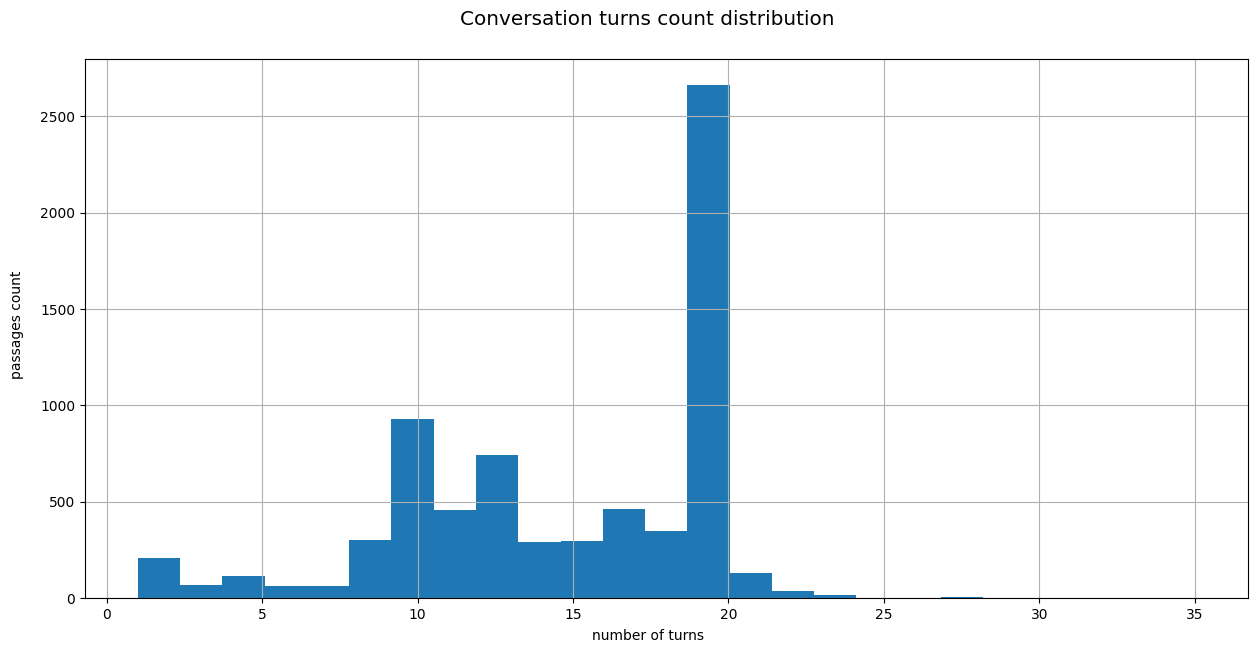

In [131]:
from utils.dataset_analisys import *
plot_converstion_length_distribution(grouped_train_df)

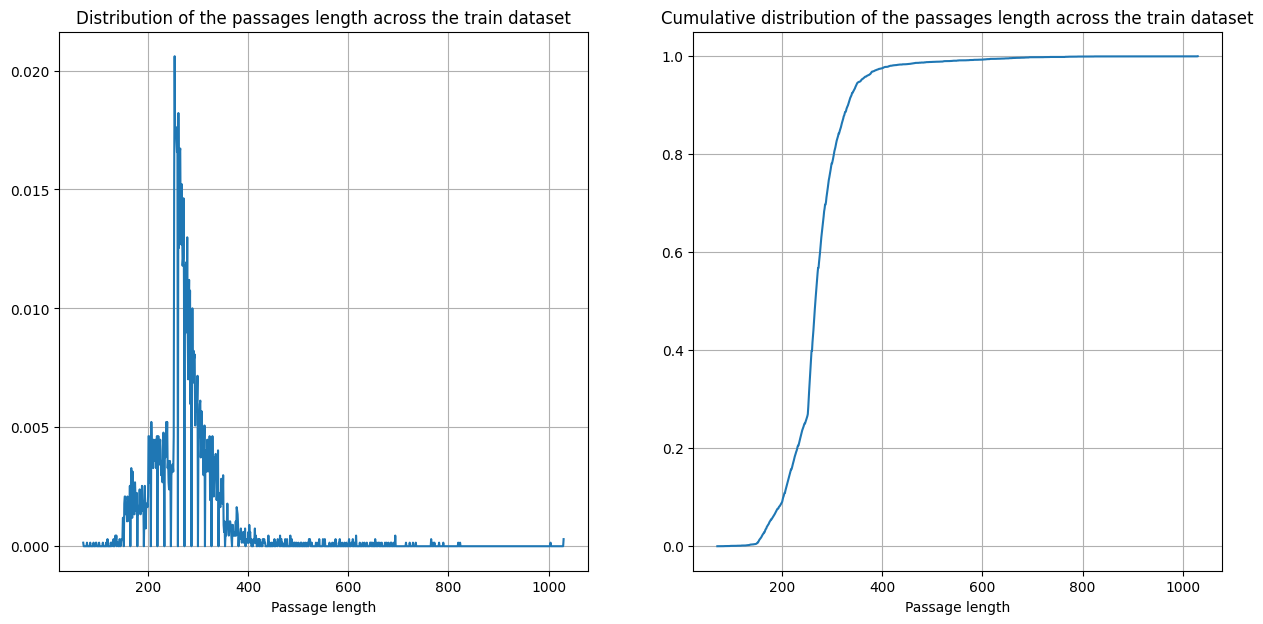

In [132]:
plot_passage_length_analysis(grouped_train_df.story.unique())

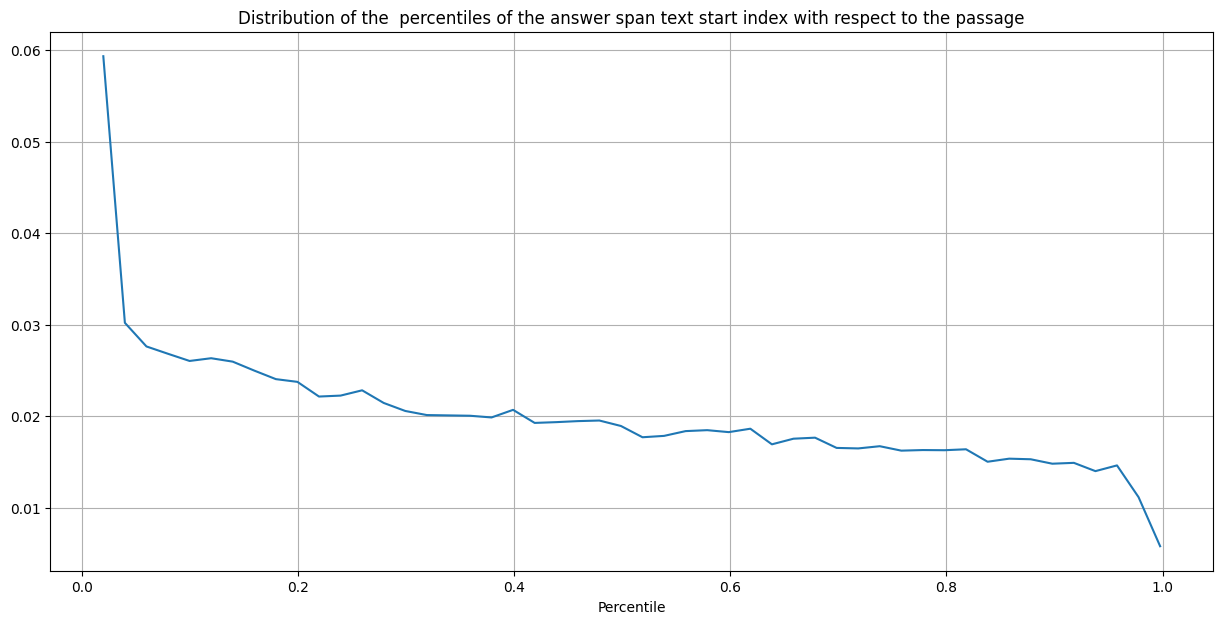

In [133]:
plot_answer_span_text_percentile(train_df)

## [Task 2] Train, Validation and Test splits

In this section the train dataframe is split into an actual train and a validation dataframes.

The split is performed as follows:
1. The random seed is set to $42$ for reproducibility purposes.
2. The train proportion of the actual training dataset to the original dataset is of $0.8$.
3. The train dataframe is shuffled and divided into the two new dataframes making sure that no conversation is split among them.

In [134]:
set_random_seed(42)

In [135]:
from sklearn.model_selection import GroupShuffleSplit
from typing import Tuple

def train_validation_split(df: pd.DataFrame, train_size: int = .8, random_seed: int = 42) \
    -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ Get train and validation dataframes by shuffling and splitting an original dataframe according to a given proportion
    and a specific random seed.
    
    Note: The order of the rows of the same conversation is preserved in the shuffle. Moreover, the conversations are never
    split across the two resulting dataframes.

    Parameters
    ----------
    df : DataFrame
        The dataframe from which the train and validation dataframes are obtained.
    train_size : int, optional
        The proportion of the train split. Defaults to 0.8.
    random_seed : int, optional
        The random seed for the shuffle. Defaults to 42.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: _description_
    """
    # Get indices of train and test rows in the dataframe
    group_shuffle_split = GroupShuffleSplit(n_splits=2, train_size=train_size, random_state=random_seed)
    train_ix, test_ix = next(group_shuffle_split.split(df, groups=df.id))

    train_df = df.loc[train_ix]
    train_df.reset_index(inplace=True, drop=True)
    
    val_df = df.loc[test_ix]
    val_df.reset_index(inplace=True, drop=True)
    
    return train_df, val_df

In [136]:
train_df, val_df = train_validation_split(train_df)

The tail of the obtain dataframe (`train_df`) and the head of the validation dataframe (`val_df`) are shown below to assert that the conversations are not splitted and that their question-answer pairs are still chronologically ordered.

In [137]:
print(f'Train dataframe shape after the split: {train_df.shape}')
train_df.tail()

Train dataframe shape after the split: (85824, 10)


,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
85819,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was a sub?,1405,1427,substitute Xabi Alonso,Xabi Alonso,10,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85820,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Was it his first game this year?,1415,1467,Xabi Alonso made his first appearance of the ...,Yes,11,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85821,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,What position did the team reach?,1520,1555,Real moved up to third in the table,third,12,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85822,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was ahead of them?,1557,1582,six points behind Barca.,Barca.,13,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85823,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,By how much?,1557,1581,six points behind Barca.,six points,14,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."


In [138]:
print(f'Validation dataframe shape after the split: {val_df.shape}')
val_df.head()

Validation dataframe shape after the split: (21452, 10)


,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,Where was the Auction held?,243,284,Hard Rock Cafe in New York's Times Square,Hard Rock Cafe,1,[]
1,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,How much did they make?,180,210,reaping a total $2 million. \n,$2 million.,2,"[Where was the Auction held?, Hard Rock Cafe]"
2,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,How much did they expected?,292,342,"pre-sale expectations of only $120,000 in sal...","$120,000",3,"[Where was the Auction held?, Hard Rock Cafe, ..."
3,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,WHo buy the Jackson Glove,1295,1365,"Hoffman Ma, who bought the glove on behalf of ...",Hoffman Ma,4,"[Where was the Auction held?, Hard Rock Cafe, ..."
4,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,Where was the buyer of the glove from?,1331,1366,"behalf of Ponte 16 Resort in Macau,",Macau,5,"[Where was the Auction held?, Hard Rock Cafe, ..."


In [139]:
print(f'Train passages count: {len(train_df.groupby(by=["id"]))}')
print(f'Validation passages count: {len(val_df.groupby(by=["id"]))}')

print()

len_tot=len(train_df)+len(val_df)
print(f'Train QaA count: {len(train_df)} \t\t Train QaA ratio: {len(train_df)/len_tot:.2f}')
print(f'Validation QaA count: {len(val_df)} \t Validation QaA ratio: {len(val_df)/len_tot:.2f}')

Train passages count: 5754
Validation passages count: 1439

Train QaA count: 85824 		 Train QaA ratio: 0.80
Validation QaA count: 21452 	 Validation QaA ratio: 0.20


In addition, the train, validation and test dataloaders are provided for future training purposes.

In [140]:
from utils.dataloader_builder import get_dataloader

train_dataloader = get_dataloader(train_df, batch_size=8)
val_dataloader = get_dataloader(val_df)
test_dataloader = get_dataloader(test_df)

## [Task 3] Model definition

In [141]:
model_name_M1 = 'distilroberta-base'
model_name_M2 = 'prajjwal1/bert-tiny'

In [142]:
from models.model import Model 

M1 = Model(model_name=model_name_M1, device='cuda')
M2 = Model(model_name=model_name_M2, device='cuda')

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializin

## [Task 4] Question generation with text passage $P$ and question $Q$

In [143]:
sample_index = 5

question_sample = [train_df.iloc[sample_index]['question']]
passage_sample = [train_df.iloc[sample_index]['story']]
answer_sample = train_df.iloc[sample_index]['answer']
history_sample = [' <sep> '.join(train_df.iloc[sample_index]['history'])]

In [144]:
print(f'Passage sample: "{passage_sample[0][:100]}..."')
print()
print(f'Question sample: "{question_sample[0]}"')
print()

questions_of_sample = train_df.iloc[sample_index]['history'][::2]
answers_of_sample = train_df.iloc[sample_index]['history'][1::2]
questions_and_answers_of_sample = [f'Q{i+1}: "{q}"; A{i+1}: "{a}"' 
                                   for i, (q, a) in enumerate(zip(questions_of_sample, answers_of_sample))]
history_string = '; '.join(questions_and_answers_of_sample)

print(f'History sample: "{history_string}"')

Passage sample: "The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the..."

Question sample: "how do scholars divide the library?"

History sample: "Q1: "When was the Vat formally opened?"; A1: "It was formally established in 1475"; Q2: "what is the library for?"; A2: "research"; Q3: "for what subjects?"; A3: "history, and law"; Q4: "and?"; A4: "philosophy, science and theology"; Q5: "what was started in 2014?"; A5: "a  project""


In [145]:
print(f'Question sample: "{question_sample[0]}"')
print()
print(f'Predicted answer by the first model: "{M1.generate(passage_sample, question_sample)[0]}"')
print()
print(f'Predicted answer by the second model: "{M2.generate(passage_sample, question_sample)[0]}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "how do scholars divide the library?"

Predicted answer by the first model: ".,"

Predicted answer by the second model: "mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar"

True answer: "into periods"


## [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

In [146]:
print(f'Question sample: "{question_sample[0]}"')
print()
print(f'Predicted answer by the first model: "{M1.generate(passage_sample, question_sample, history=history_sample)[0]}"')
print()
print(f'Predicted answer by the second model: "{M2.generate(passage_sample, question_sample, history=history_sample)[0]}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "how do scholars divide the library?"

Predicted answer by the first model: ".,"

Predicted answer by the second model: "mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar"

True answer: "into periods"


## [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

### 6.1 distilroberta-base

In [ ]:
# Set the seed for reproducibility (options: 42; 2022; 1337)
seed_M1 = 2022
# Set whether to use history or not
use_history_M1 = True

In [41]:
from utils.checkpoint_loader import get_checkpoint_path, load_checkpoints

checkpoint_path_M1 = get_checkpoint_path(model_name_M1, seed_M1, use_history_M1)

# Reinitialize the model with the set random seed
set_random_seed(seed_M1)
M1 = Model(model_name=model_name_M1, device='cuda')

In [42]:
loss_history, val_loss_history, optimizer_state_dict = load_checkpoints(M1, checkpoint_path_M1)

Unable to load saved files, default initialization


In [ ]:
from utils.training import train

train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epochs=3, model=M1, use_history=use_history_M1, 
      checkpoint_path=checkpoint_path_M1, loss_history = list(loss_history) if loss_history is not None else None,
      val_loss_history=list(val_loss_history) if loss_history is not None else None, steps_validate=0.33, steps_save=0.1,
      device='cuda')

'epoch: 1/3, 10728/10728, 6922s 645ms/step, lr: 5e-05, forcing=0.75, loss: 0.463 1.74'

'epoch: 2/3, 10728/10728, 6929s 646ms/step, lr: 5e-05, forcing=0.25, loss: 0.327 0.745'

'epoch: 3/3, 10728/10728, 6914s 645ms/step, lr: 5e-05, forcing=2.38e-09, loss: 0.288 0.594'

In [45]:
from utils.train_analysis import plot_training_history
plot_training_history(checkpoint_path_M1)

FileNotFoundError: [Errno 2] No such file or directory: 'weigths/PQ/seed42\\distilroberta-base.pth'

In [ ]:
from utils.squad import validate
f1_squad = validate(M1, val_dataloader, use_history=use_history_M1)
print(f'Mean SQuAD F1-score on the validation set of the "distilroberta-base" model: {f1_squad}')
print()
f1_squad = validate(M1, test_dataloader, use_history=use_history_M1)
print(f'Mean SQuAD F1-score on the test set of the "distilroberta-base" model: {f1_squad}')

Mean SQuAD F1-score on the validation set of the "bert-tiny" model: 0.5028064156884385

Mean SQuAD F1-score on the test set of the "bert-tiny" model: 0.5234226971019368


#### 6.1.1 Results

##### Validation mean SQuAD F1-score summary

|               |   No-History    | History         |
| :------------ | :-------------: | :--------------:|
|   seed 42     | 0.48132         | 0.49752         |
|   seed 2022   | 0.47511         | 0.50281         |
|   seed 1337   | 0.44120         | 0.48739         |

##### Test mean SQuAD F1-score summary

|               |   No-History    | History         |
| :------------ | :-------------: | :--------------:|
|   seed 42     | 0.49185         |  0.51392        |
|   seed 2022   | 0.49350         |  0.52342        |
|   seed 1337   | 0.44890         |  0.51066        |



### 6.2 prajjwal1/bert-tiny

In [37]:

# Set the seed for reproducibility (options: 42; 2022; 1337)
seed_M2 = 2022
# Set whether to use history or not
use_history_M2 = False

In [38]:
from utils.checkpoint_loader import get_checkpoint_path, load_checkpoints

checkpoint_path_M2 = get_checkpoint_path(model_name_M2, seed_M2, use_history_M2)

# Reinitialize the model with the set random seed
set_random_seed(seed_M2)
M2 = Model(model_name=model_name_M2, device='cuda')


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.

In [52]:
loss_history, val_loss_history, optimizer_state_dict = load_checkpoints(M2, checkpoint_path_M2)

Loaded saved files


In [ ]:
from utils.training import train

train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epochs=3, model=M2, use_history=use_history_M2, 
      checkpoint_path=checkpoint_path_M2, loss_history = list(loss_history) if loss_history is not None else None,
      val_loss_history=list(val_loss_history) if loss_history is not None else None, steps_validate=0.33, 
      steps_save=0.1, device='cuda')

'epoch: 1/3, 10728/10728, 647s 60ms/step, lr: 5e-05, forcing=0.75, loss: 0.922 1.89'

/kaggle/working/NLP-assignment-2/models/encoder_decoder_bertTiny.py:145: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


'epoch: 2/3, 10728/10728, 649s 60ms/step, lr: 5e-05, forcing=0.25, loss: 0.778 1.29'

'epoch: 3/3, 10728/10728, 646s 60ms/step, lr: 5e-05, forcing=2.38e-09, loss: 0.718 1.26'

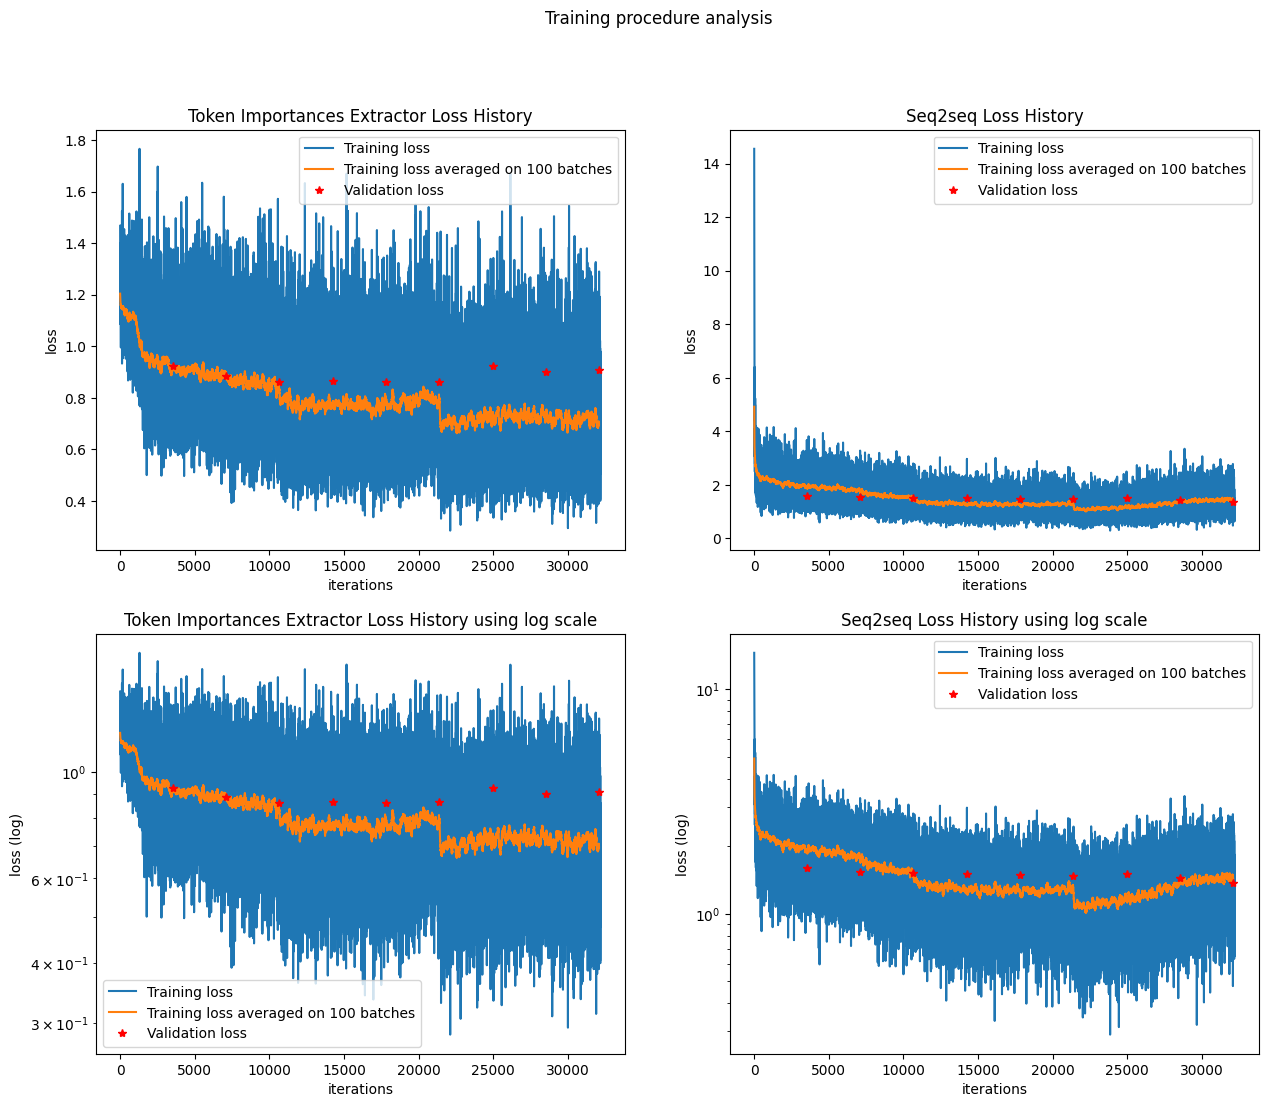

In [39]:
from utils.train_analysis import plot_training_history
plot_training_history(checkpoint_path_M2)

In [53]:
from utils.squad import validate
f1_squad = validate(M2, val_dataloader, use_history=use_history_M2)
print(f'Mean SQuAD F1-score on the validation set of the "bert-tiny" model: {f1_squad}')
print()
f1_squad = validate(M2, test_dataloader, use_history=use_history_M2)
print(f'Mean SQuAD F1-score on the test set of the "bert-tiny" model: {f1_squad}')

Mean SQuAD F1-score on the test set of the "bert-tiny" model: 0.23501837090792735


#### 6.2.1 Results

##### Validation mean SQuAD F1-score summary

|               |   No-History    | History         |
| :------------ | :-------------: | :--------------:|
|   seed 42     | 0.23645         | 0.22185         |
|   seed 2022   | 0.24117         | 0.23626         |
|   seed 1337   | 0.24062         | 0.23203         |

##### Test mean SQuAD F1-score summary

|               |   No-History    | History         |
| :------------ | :-------------: | :--------------:|
|   seed 42     | 0.23854         | 0.23488         |
|   seed 2022   | 0.24610         | 0.24361         |
|   seed 1337   | 0.25225         | 0.23502         |

Given the results, it is evident how the use of the Question and Answer history to generate the next answer worsen the performances. The reason behind this behaviour can probably be found in the fact that a greater part of the passage is lost to truncation hence the span of the passage corresponding to the question may be not present.

## [Task 7] Error Analysis

In [148]:
grouped_test_df = test_df.groupby(by=['source'])
print(f'Number of sources: {len(grouped_test_df)}')
print(f'Source names: {"; ".join([key for key, _ in grouped_test_df])}.')

Number of sources: 5
Source names: cnn; gutenberg; mctest; race; wikipedia.


### 7.1 distilroberta-base

In [45]:
from models.model import Model 
from utils.checkpoint_loader import get_checkpoint_path, load_checkpoints

# Remove previous tensors from GPU memory
torch.cuda.empty_cache()

best_seed_M1 = 2022
use_history_M1 = True
best_checkpoints_path_M1 = get_checkpoint_path(model_name_M1, best_seed_M1, use_history_M1)


set_random_seed(best_seed_M1)
best_M1 = Model(model_name=model_name_M1, device='cuda')

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.

In [46]:
loss_history, val_loss_history, optimizer_state_dict = load_checkpoints(best_M1, best_checkpoints_path_M1)

Loaded saved files


In [48]:
from utils.error_analysis import get_worst_answers, show_worst_errors, plot_token_importances

sources_statistics_dict = dict()
for source, df_source in grouped_test_df:
    sources_statistics_dict[source] = get_worst_answers(best_M1, df_source, False)

  7%|▋         | 7/103 [00:12<02:49,  1.77s/it]


KeyboardInterrupt: 

In [145]:
print(f'Source names: {"; ".join(sources_statistics_dict.keys())}.')

Source names: cnn; gutenberg; mctest; race; wikipedia.


CNN

In [146]:
show_worst_errors('cnn', sources_statistics_dict)

* Passage: "(CNN)As art, film stills are often overlooked. 

The photographers tend to be anonymous; it's easy t..."
* Question: "According to Jacob was the photographers creating art work for the future?"
* Gold Answer: "Yes"
* Predicted Answer: "the magazine"
* F1 SQuAD: 0.0

* Passage: "Los Angeles (CNN) -- Two years after his death, music legend and celebrity icon Michael Jackson's le..."
* Question: "After death was he forgotten?"
* Gold Answer: "No!"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "(CNN) -- For Heather Neroy, it used to be a tedious process: Whenever she came across an interesting..."
* Question: "After that?"
* Gold Answer: "a shared color board"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "(CNN) -- President Barack Obama has nominated his top counterterrorism adviser, John Brennan, to be ..."
* Question: "After what event was it passed?"
* Gold Answer: "The September 11 attacks."
* Predicted Answer: "military"
* F1 SQuAD: 0.0

* Passage: "(CNN) 

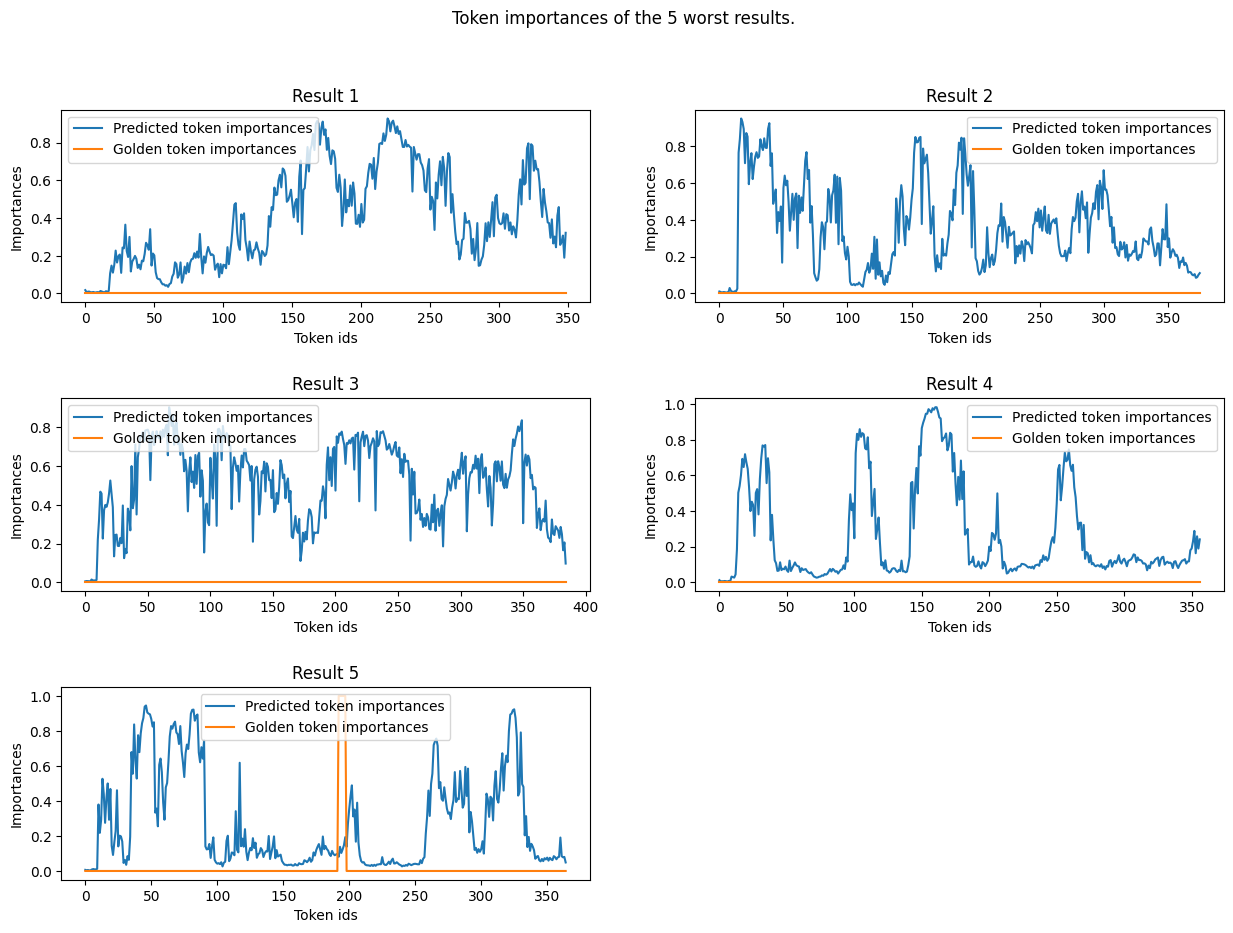

In [147]:
plot_token_importances('cnn', sources_statistics_dict, best_M1)

Gutenberg

In [148]:
show_worst_errors('gutenberg', sources_statistics_dict)

* Passage: "Chapter 17: The Battle Of Moncontor. 

When Pierre left him in order to look after the horses, Phili..."
* Question: "About what?"
* Gold Answer: "that she has spoken to him"
* Predicted Answer: "the horses"
* F1 SQuAD: 0.0

* Passage: "CHAPTER XXIII 

A SLIDE DOWN THE MOUNTAIN SIDE 

"My gracious, Dick! It sure is snowing some now!" 
..."
* Question: "After how many times?"
* Gold Answer: "at least ten"
* Predicted Answer: "three"
* F1 SQuAD: 0.0

* Passage: "CHAPTER VIII 



Five minutes after Paula had left him, punctual to the second, the four telegrams d..."
* Question: "Along with who?"
* Gold Answer: "Thayer"
* Predicted Answer: "dewey"
* F1 SQuAD: 0.0

* Passage: "CHAPTER NINETEEN. 

A SHOOTING TRIP TO PARADISE ISLE, AND FURTHER DISPLAY OF THE CAPTAIN'S CONTRIVAN..."
* Question: "An insignificant one?"
* Gold Answer: "the main one"
* Predicted Answer: "no"
* F1 SQuAD: 0.0

* Passage: "CHAPTER NINETEEN. 

A SHOOTING TRIP TO PARADISE ISLE, AND FURTHER DISPLAY OF THE C

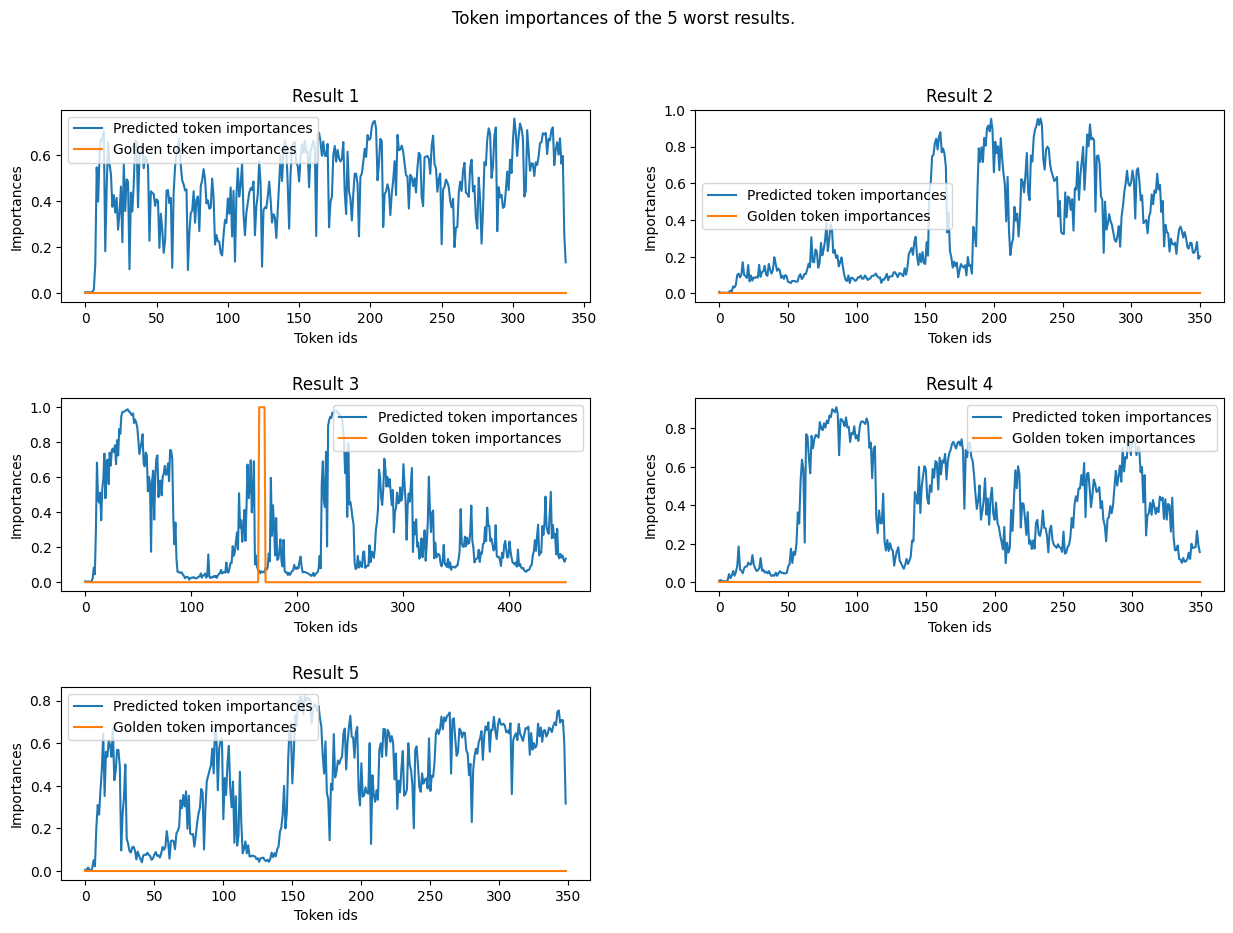

In [149]:
plot_token_importances('gutenberg', sources_statistics_dict, best_M1)

McTest

In [150]:
show_worst_errors('mctest', sources_statistics_dict)

* Passage: "Tom had to fix some things around the house. He had to fix the door. He had to fix the window. But b..."
* Question: "After completing the repairs what did everyone do?"
* Gold Answer: "Made dinner."
* Predicted Answer: "next door"
* F1 SQuAD: 0.0

* Passage: "My puppy is a boy puppy. His name is Snow. He is white like snow. Snow has a dog house. It is blue. ..."
* Question: "Am I sad to see him?"
* Gold Answer: "no"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "Once upon a time there were four children. Each of the children had a favorite color. John's favorit..."
* Question: "And Alice's?"
* Gold Answer: "Yellow."
* Predicted Answer: "pink"
* F1 SQuAD: 0.0

* Passage: "Once upon a time there were four children. Each of the children had a favorite color. John's favorit..."
* Question: "And Jack's?"
* Gold Answer: "Red."
* Predicted Answer: "blue"
* F1 SQuAD: 0.0

* Passage: "A little boy named Joey did not like to brush his teeth. One day, as his mother asked him 

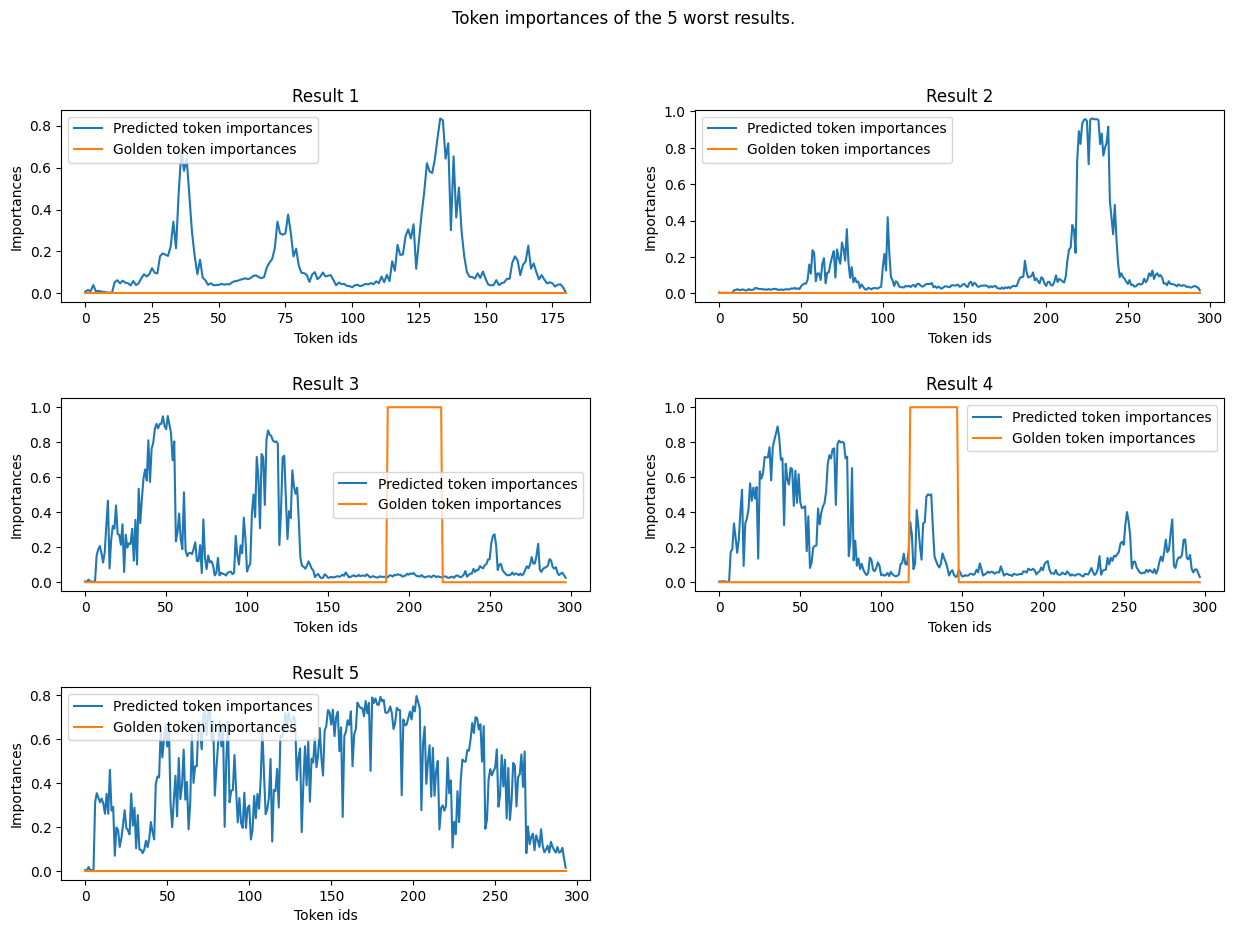

In [151]:
plot_token_importances('mctest', sources_statistics_dict, best_M1)

Race

In [152]:
show_worst_errors('race', sources_statistics_dict)

* Passage: "Lin Xiao, 21, a student at Guangdong University, has a big family - her two parents, a younger broth..."
* Question: "According to the new policy, how many children are now allowed?"
* Gold Answer: "two"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "For millions of years, sharks have been the kings of the oceans, the top of the food chain. But thes..."
* Question: "According to who?"
* Gold Answer: "Luke Tipple"
* Predicted Answer: "fish"
* F1 SQuAD: 0.0

* Passage: ""It's 8:15 on a Sunday morning," said the officer, Tidwell, "and this sort of thing seems an unlikel..."
* Question: "According to whom?"
* Gold Answer: "the officer"
* Predicted Answer: "his friend"
* F1 SQuAD: 0.0

* Passage: "Many of us use them several times a day without really noticing.And yet the way we in lifts,or eleva..."
* Question: "According to whom?"
* Gold Answer: "Babette Renneberg"
* Predicted Answer: "babe"
* F1 SQuAD: 0.0

* Passage: "The Labrador has won the honor of the most popula

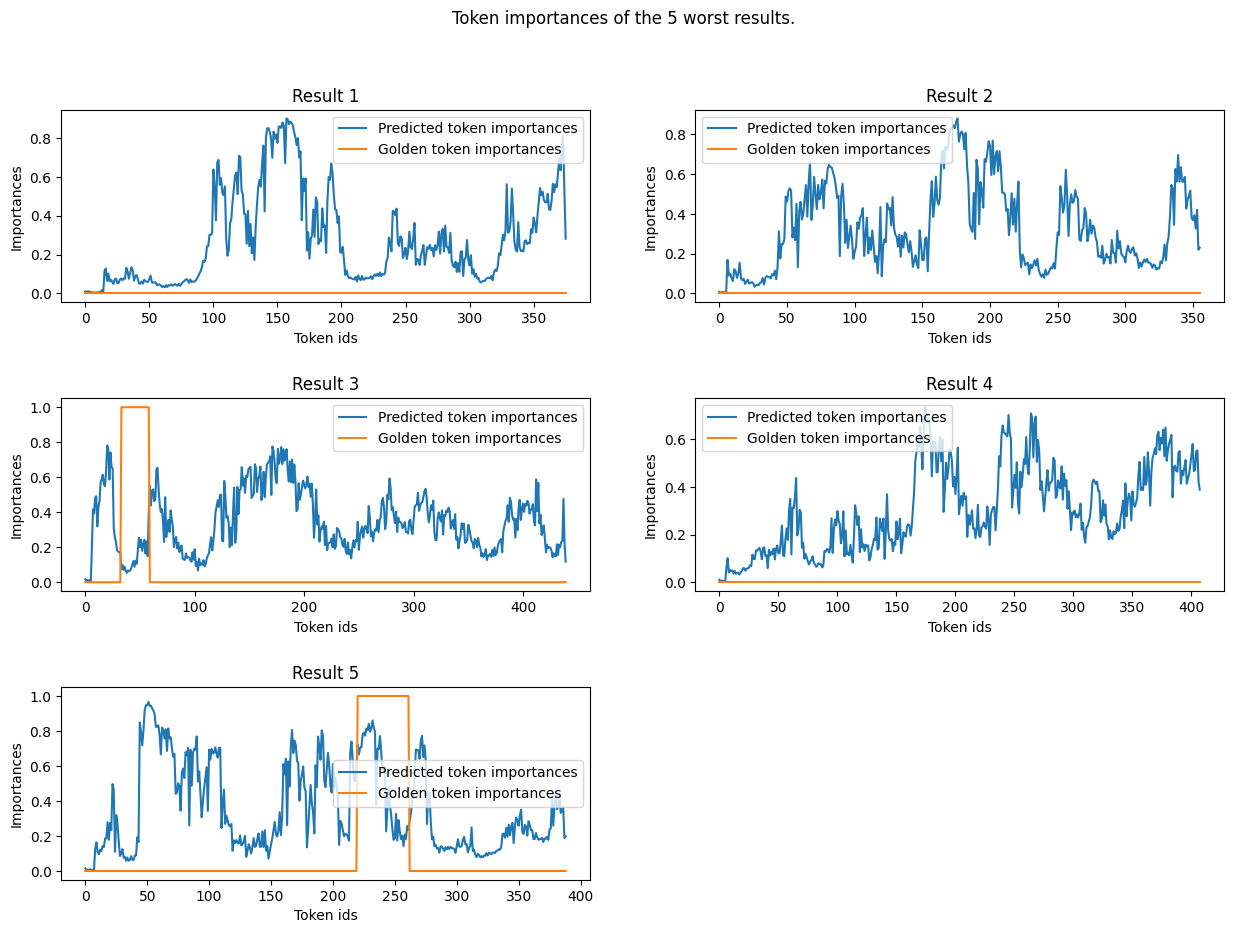

In [153]:
plot_token_importances('race', sources_statistics_dict, best_M1)

Wikipedia

In [154]:
show_worst_errors('wikipedia', sources_statistics_dict)

* Passage: "Education is the process of facilitating learning, or the acquisition of knowledge, skills, values, ..."
* Question: "After Rome fell, who was the only preserver of literate scholarship in Western Europe?"
* Gold Answer: "the Catholic Church"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "Germany, officially the Federal Republic of Germany, is a federal parliamentary republic in central-..."
* Question: "After that event, What was the Empire replaced by?"
* Gold Answer: "Weimar Republic."
* Predicted Answer: "the collapse of the death"
* F1 SQuAD: 0.0

* Passage: "Endemism is the ecological state of a species being unique to a defined geographic location, such as..."
* Question: "And "demos"?"
* Gold Answer: ""the people""
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage: "Pope Benedict XVI (; ; ; born Joseph Aloisius Ratzinger; ; born 16 April 1927) served as Pope from 2..."
* Question: "And his last name?"
* Gold Answer: "Ratzinger"
* Predicted Answer: "the po

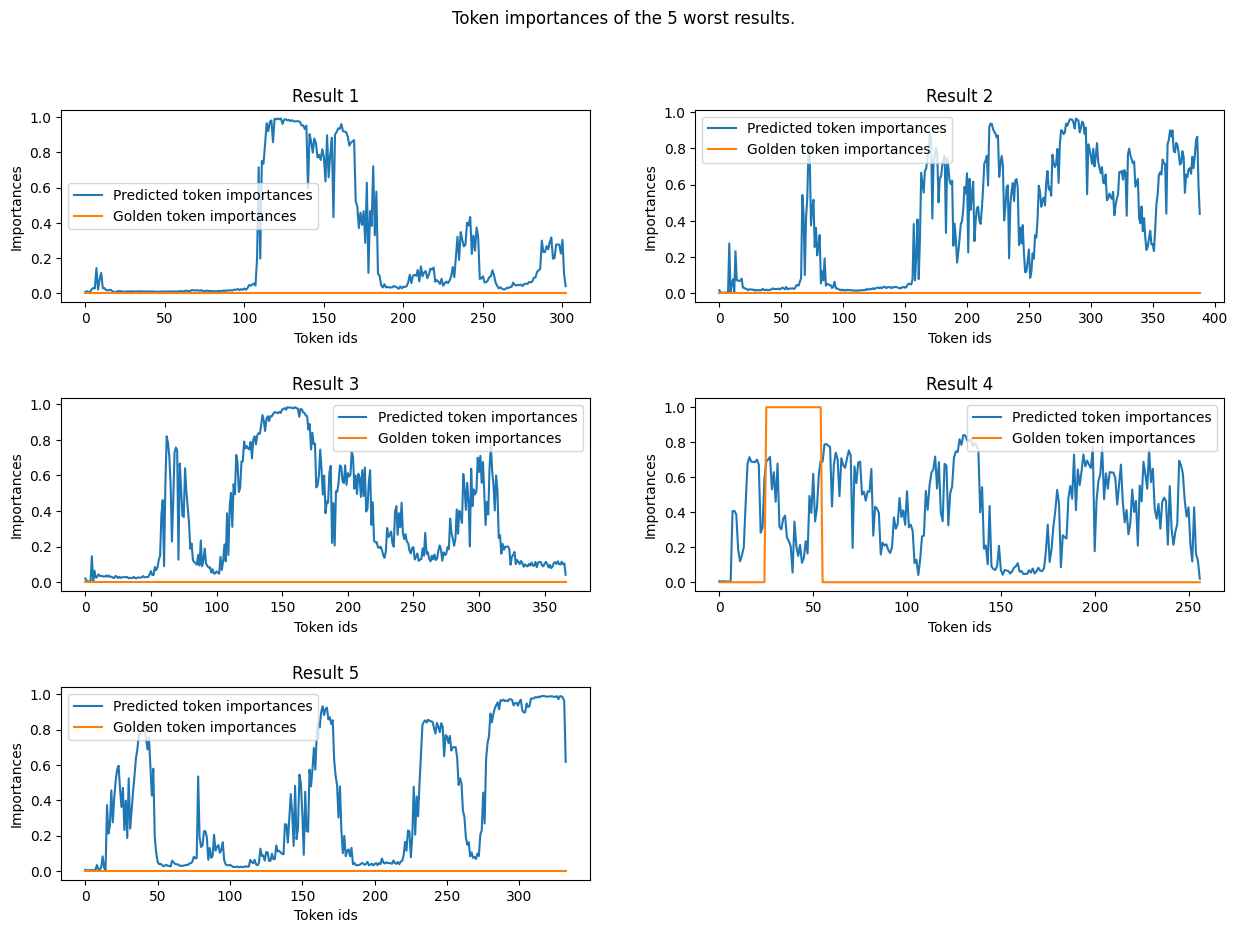

In [155]:
plot_token_importances('wikipedia', sources_statistics_dict, best_M1)

### 7.2 prajjwal1/bert-tiny

In [147]:
from models.model import Model 
from utils.checkpoint_loader import get_checkpoint_path, load_checkpoints

# Remove previous tensors from GPU memory
torch.cuda.empty_cache()

best_seed_M2 = 2022
use_history_M2 = False
best_checkpoints_path_M2 = get_checkpoint_path(model_name_M2, best_seed_M2, use_history_M2)


set_random_seed(best_seed_M2)
best_M2 = Model(model_name=model_name_M2, device='cuda')

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.

In [149]:
loss_history, val_loss_history, optimizer_state_dict = load_checkpoints(best_M2, best_checkpoints_path_M2)

Loaded saved files


In [150]:
from utils.error_analysis import get_worst_answers, show_worst_errors, plot_token_importances

sources_statistics_dict = dict()
for source, df_source in grouped_test_df:
    sources_statistics_dict[source] = get_worst_answers(best_M2, df_source, use_history=use_history_M2)

100%|██████████| 101/101 [00:36<00:00,  2.79it/s]


CNN

In [151]:
show_worst_errors('cnn', sources_statistics_dict, show_history=use_history_M2)

* Question: "A source mentioned that Jordan will use what against the terrorists?"
* Gold Answer: "airstrikes."
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Question: "According to whom?"
* Gold Answer: "Georgian Interior Ministry"
* Predicted Answer: "russian"
* F1 SQuAD: 0.0

* Question: "Across what ocean?"
* Gold Answer: "the Pacific"
* Predicted Answer: "miles"
* F1 SQuAD: 0.0

* Question: "After that?"
* Gold Answer: "a shared color board"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Question: "After what?"
* Gold Answer: "a road rage incident"
* Predicted Answer: "the investigation"
* F1 SQuAD: 0.0



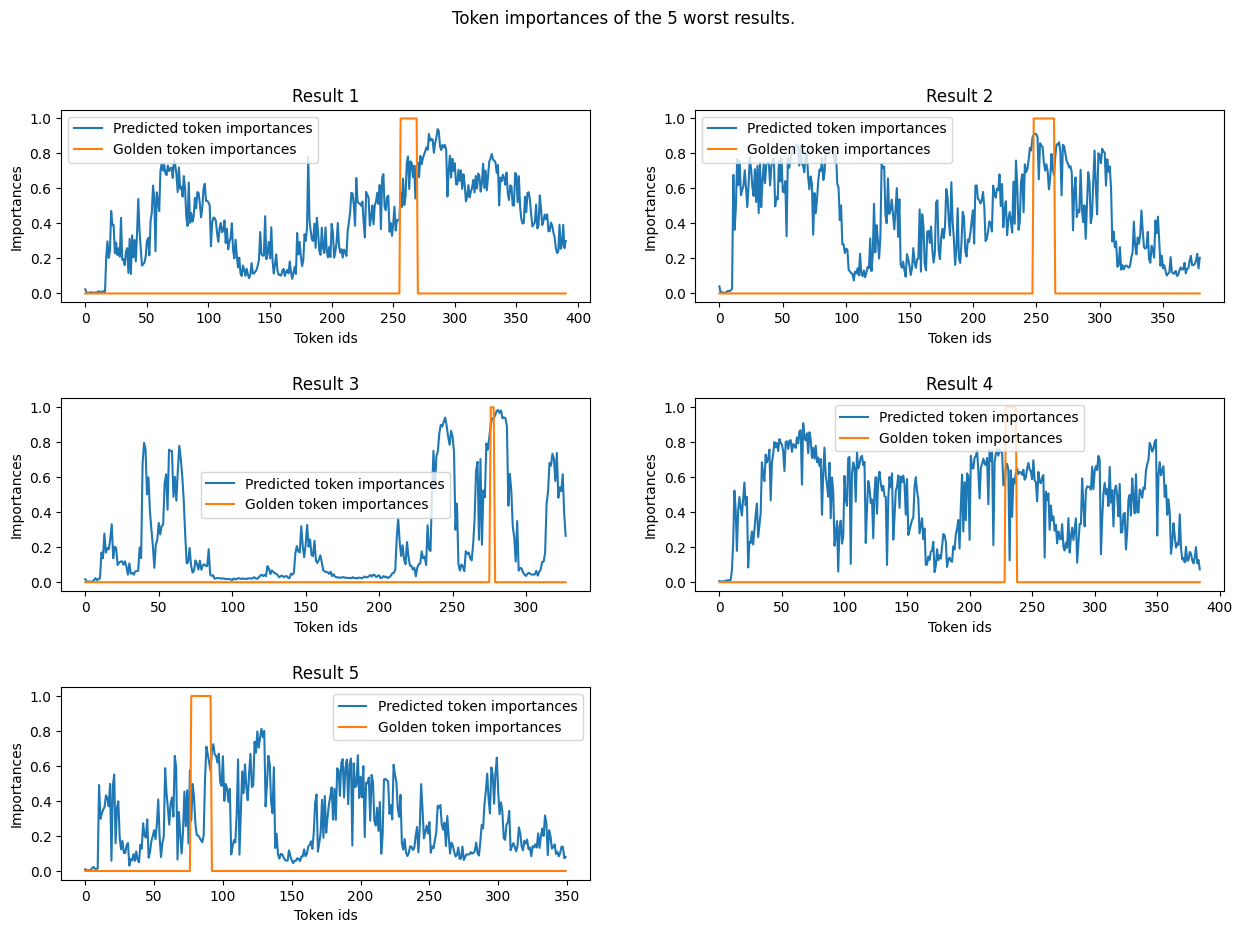

In [164]:
plot_token_importances('cnn', sources_statistics_dict, best_M2, use_history=use_history_M2)

Gutenberg

In [165]:
show_worst_errors('gutenberg', sources_statistics_dict, show_history=use_history_M2)

* Question: "According to who?"
* Gold Answer: "Donovan"
* Predicted Answer: "bill"
* F1 SQuAD: 0.0

* Question: "After how many times?"
* Gold Answer: "at least ten"
* Predicted Answer: "three"
* F1 SQuAD: 0.0

* Question: "Along with who?"
* Gold Answer: "Thayer"
* Predicted Answer: "harriet"
* F1 SQuAD: 0.0

* Question: "And Merwell's?"
* Gold Answer: "Link"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Question: "And her name?"
* Gold Answer: "Miriam"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0



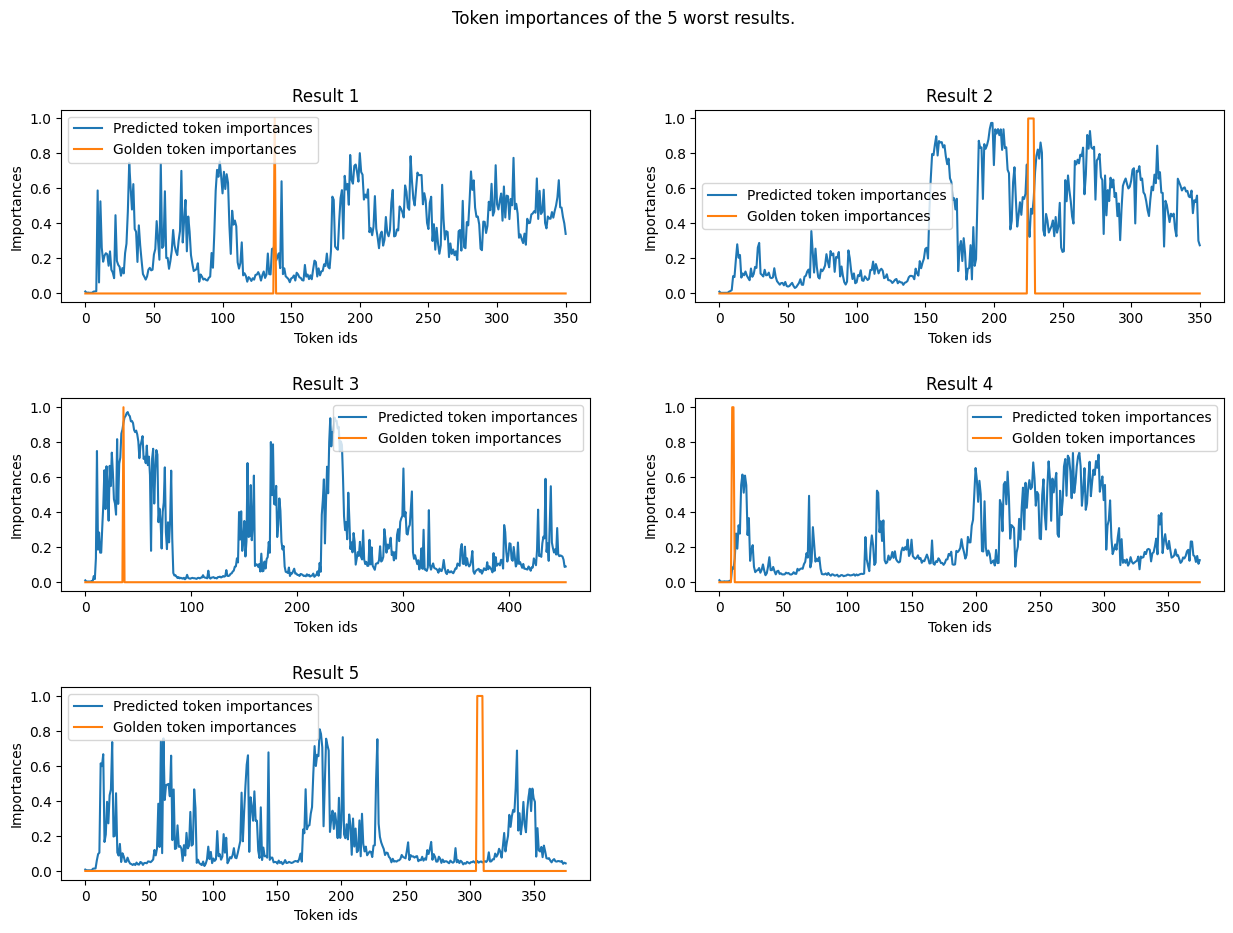

In [166]:
plot_token_importances('gutenberg', sources_statistics_dict, best_M2, use_history=use_history_M2)

McTest

In [168]:
show_worst_errors('mctest', sources_statistics_dict, show_history=use_history_M2)

* Question: "Am I sad to see him?"
* Gold Answer: "no"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Question: "And after that?"
* Gold Answer: "she walked to the drier"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Question: "And did what?"
* Gold Answer: "He pushed the boy"
* Predicted Answer: "a teacher"
* F1 SQuAD: 0.0

* Question: "And then do what?"
* Gold Answer: "remember the happiest she ever felt"
* Predicted Answer: "the star"
* F1 SQuAD: 0.0

* Question: "And what about the seed?"
* Gold Answer: "yes"
* Predicted Answer: "strawberries"
* F1 SQuAD: 0.0



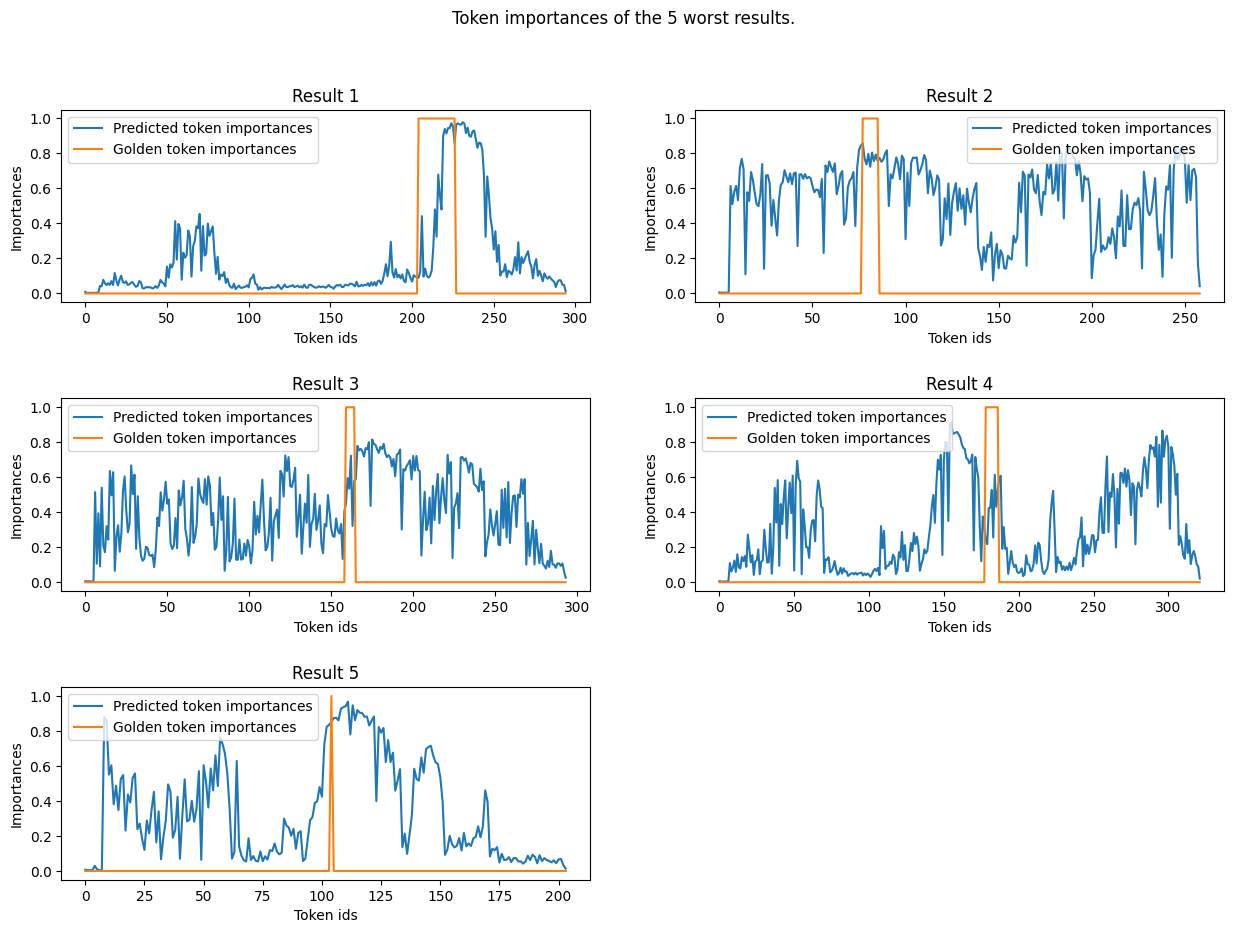

In [181]:
plot_token_importances('mctest', sources_statistics_dict, best_M2, use_history=use_history_M2)

Race

In [182]:
show_worst_errors('race', sources_statistics_dict, show_history=use_history_M2)

* Question: "According to whom?"
* Gold Answer: "Babette Renneberg"
* Predicted Answer: "paul"
* F1 SQuAD: 0.0

* Question: "After what wars did musicians start visiting hospitals?"
* Gold Answer: "WWI and WWII"
* Predicted Answer: "the world"
* F1 SQuAD: 0.0

* Question: "Am or pm?"
* Gold Answer: "morning"
* Predicted Answer: "old man"
* F1 SQuAD: 0.0

* Question: "And his first name?"
* Gold Answer: "Thomas"
* Predicted Answer: "the doctor"
* F1 SQuAD: 0.0

* Question: "And his occupation?"
* Gold Answer: "psychologist"
* Predicted Answer: "researcher"
* F1 SQuAD: 0.0



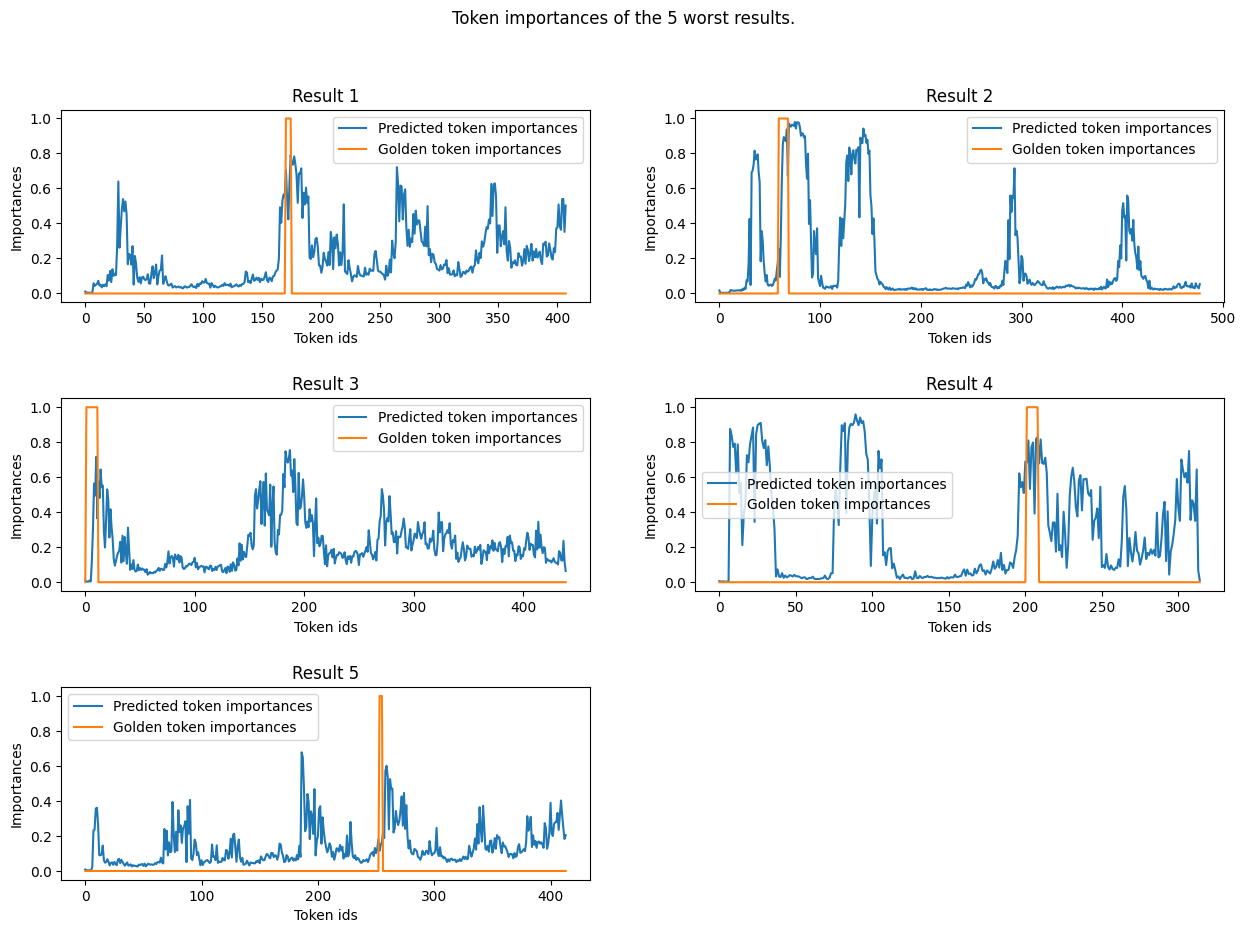

In [183]:
plot_token_importances('race', sources_statistics_dict, best_M2, use_history=use_history_M2)

Wikipedia

In [184]:
show_worst_errors('wikipedia', sources_statistics_dict, show_history=use_history_M2)

* Question: "After Rome fell, who was the only preserver of literate scholarship in Western Europe?"
* Gold Answer: "the Catholic Church"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Question: "After that event, What was the Empire replaced by?"
* Gold Answer: "Weimar Republic."
* Predicted Answer: "germany"
* F1 SQuAD: 0.0

* Question: "And another?"
* Gold Answer: "be in a Council of Europe member country"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Question: "And another?"
* Gold Answer: "Holstein"
* Predicted Answer: "jutland"
* F1 SQuAD: 0.0

* Question: "And his last name?"
* Gold Answer: "Ratzinger"
* Predicted Answer: "pope paul iii"
* F1 SQuAD: 0.0



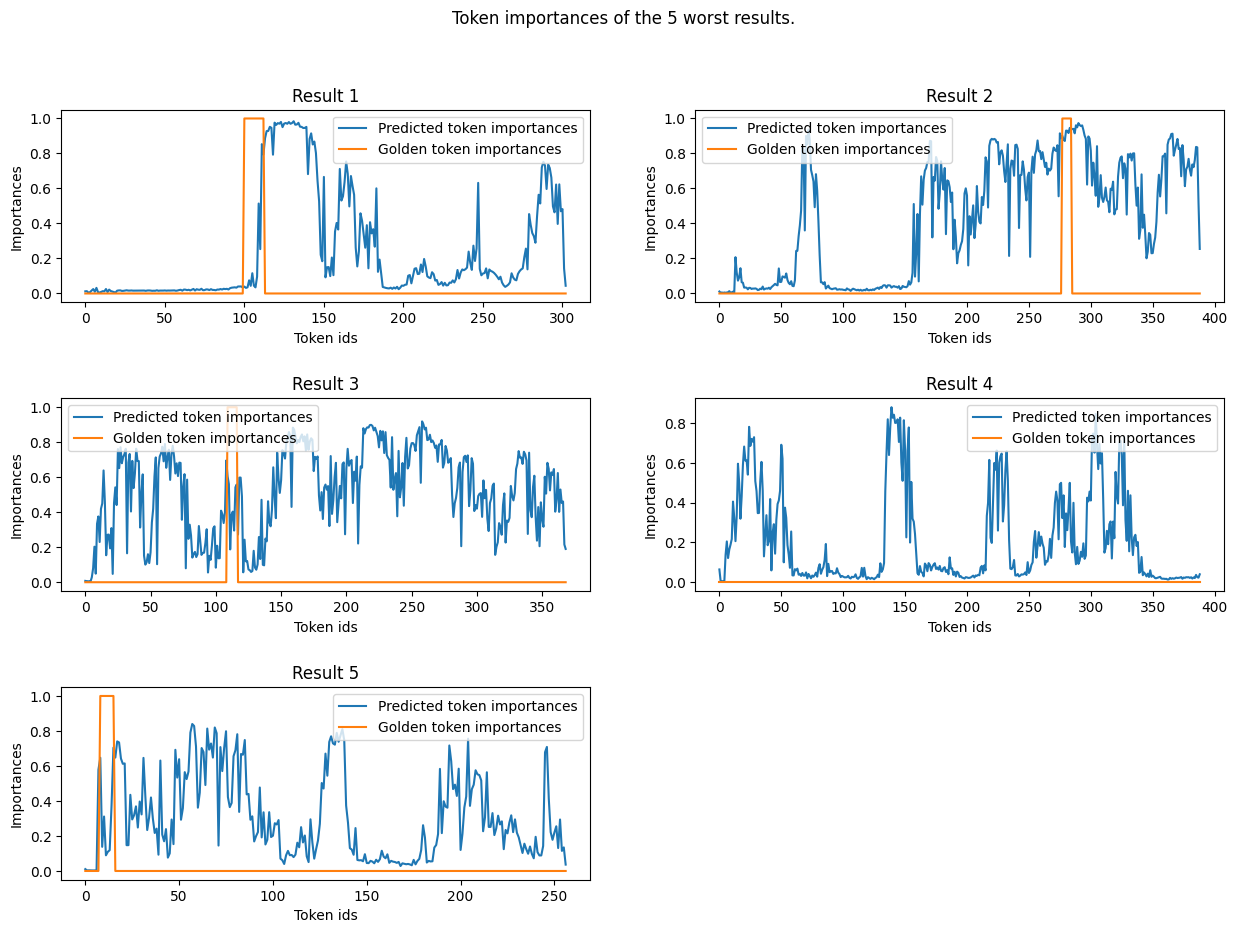

In [188]:
plot_token_importances('wikipedia', sources_statistics_dict, best_M2, use_history=use_history_M2)